<h1 align="center">数据挖掘-homework3-22210980041-胡一航</h1>


<h3 >Problem 1：利用 Newton-Raphson 算法实现逻辑回归</h3>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import font_manager
my_font = font_manager.FontProperties(family='SimHei', size=24)  

导入包，设定绘图时的中文字体。

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

定义sigmoid函数以供后续使用。

In [3]:
def IRLS(X,Y,max_iter):
    n, coefs = X.shape
    new_beta = np.zeros([coefs,1]) # beta全部初始化为0
    iter_count = 0  #记录迭代次数

    while iter_count < max_iter:
        beta = new_beta.copy() #获取当前beta
        
        p = sigmoid(X @ beta) 
        W = np.diag((p * (1 - p)).reshape(-1))
        hess = - X.T @ W @ X # 海森矩阵
        grad = X.T @ (Y - p) # 梯度向量
         
        new_beta = beta - np.linalg.inv(hess) @ grad # 更新beta
        iter_count += 1

        if np.max(abs(new_beta-beta))<1e-5:
            break
    return beta

实现IRLS算法，算法简述如下： 

对数似然函数的梯度向量和Hessian矩阵表示如下：
$$\begin{aligned} 
\frac{ \partial \mathcal{l}(\beta) }{ \partial \beta } &= X^T(y-p) \\ 
\frac{ \partial^2 \mathcal{l}(\beta) }{ \partial \beta\partial \beta^T } &= -X^T W X  
\end{aligned}$$

其中$\mathcal{l}(\beta)$是对数似然函数，$X$是自变量构成的$N * (p + 1)$的矩阵；$y$则是对应的标签向量也即因变量； 

$p$是拟合的概率值向量，其第$i$个元素为 $p(x_i;\beta^{old})=sigmod(x_i\beta^{old} )$;  

$W$为$N * N $的对角矩阵，其第$i$个对角元素为$p(x_i;\beta^{old})(1-p(x_i;\beta^{old}))$.  

更新$\beta$的方式为：

$$
\beta^{new} = \beta^{old} + (X^T W X)^{-1} X^T(y-p)
$$

In [4]:
true_beta = np.array([-0.5,0.5,-1,1]).reshape(4,1)    
N_list = [200 ,500 ,750 ,1000]  
R = 200
results_dict= {} # 用字典记录数据
for N in N_list:
    results_dict[N] = np.array([[0,0,0,0]]) # 字典的键值为N 对应值为试验的结果
    #记录当前N对应的预测值，每一行是一次试验的结果，初始化所用的第一行最后会被删掉
    for i in range(R):
        np.random.seed(i+1)
        X = np.column_stack((np.ones(N),np.random.normal(0, 1, [N,3]))) #得到 X
        p = sigmoid(X @ true_beta) # 计算相应概率
        Y = np.random.binomial(1, p) # 根据伯努利分布随机得到 Y
        predict_beta = IRLS(X,Y,float('inf')) # IRLS算法
        diff = predict_beta - true_beta
        results_dict[N] = np.r_[results_dict[N],diff.T] #记录结果    
    results_dict[N] = np.delete(results_dict[N], 0, axis=0) #删去初始化用的第一行

对于每个N值，重复200次试验并用一个字典记录数据，代码已给出必要注释。

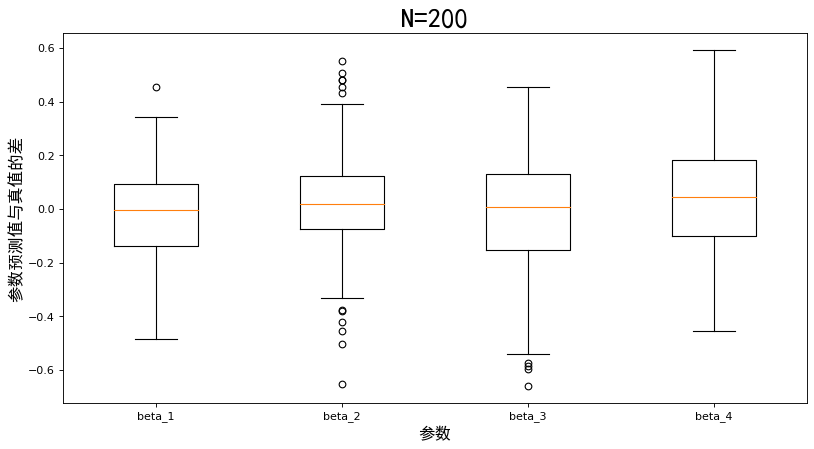

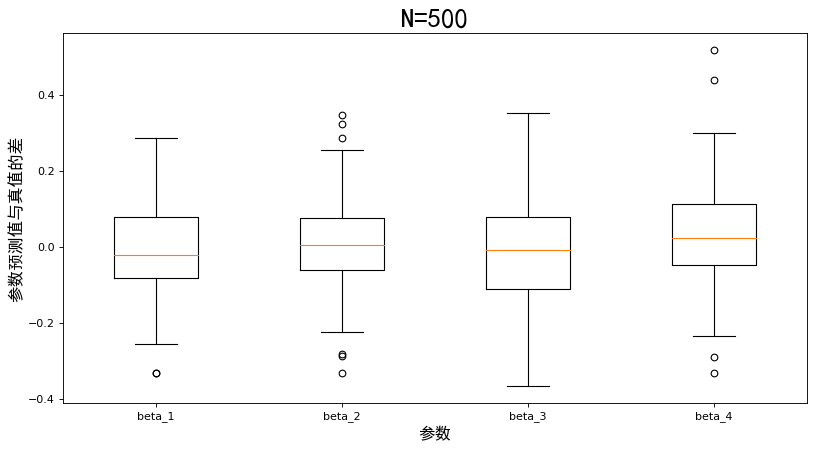

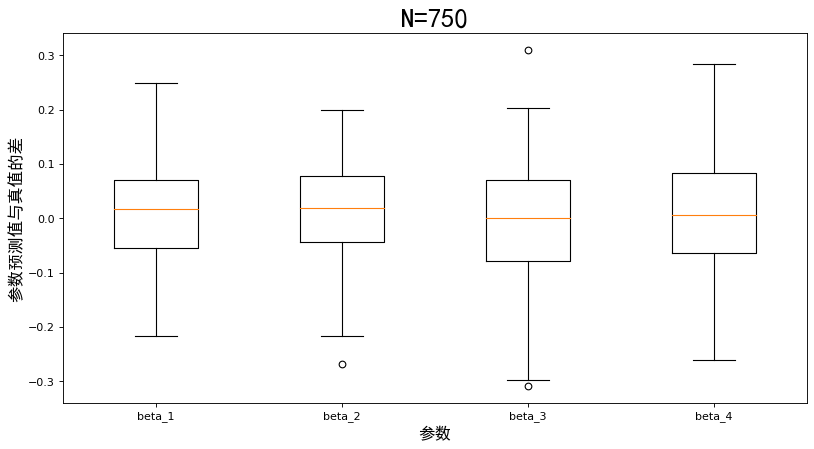

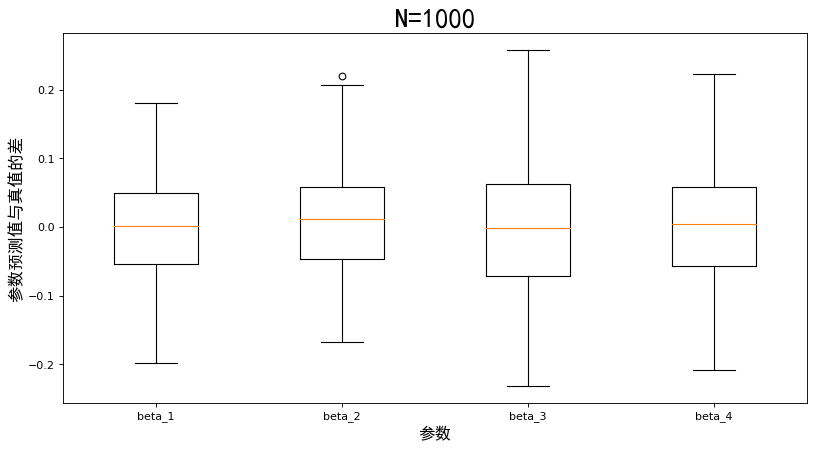

In [5]:
for N in N_list:
    data = results_dict[N]
    labels = ['beta_1','beta_2','beta_3','beta_4']
    # 这里是对应每一个N，画四个beta的箱线图

    plt.figure(figsize=(12,6),dpi=80)    
    plt.boxplot(data,labels=labels)
    plt.ylabel('参数预测值与真值的差', fontproperties=my_font,size = 15)
    plt.xlabel('参数', fontproperties=my_font,size = 15)
    plt.title('N={}'.format(N),fontproperties=my_font)
    plt.show()

这是对每一个N值，绘制所预测的4个参数的预测值与真值的差的箱线图。  
这几幅图证明了我们算法的有效性，参数的预测值与真值的差都在0左右波动，最少的200数据量也已经取得了较好的结果。  
除此感觉并不能体现出什么信息，如果一定要说的话，似乎$\hat\beta_1、\hat\beta_2$的波动相较于$\hat\beta_3、\hat\beta_4$较小。

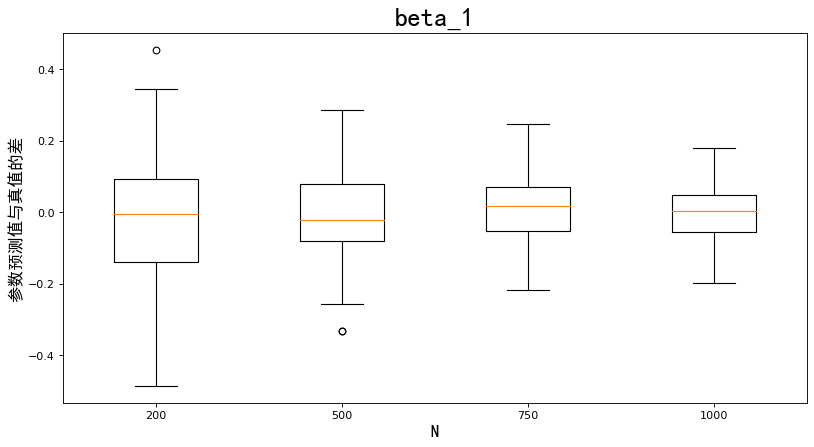

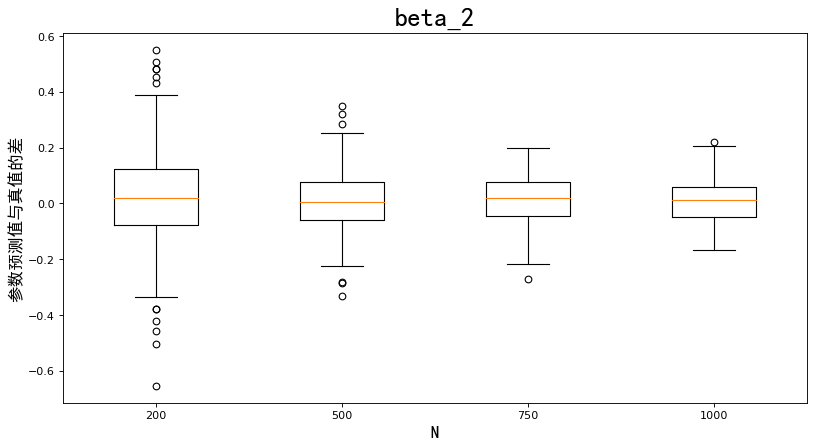

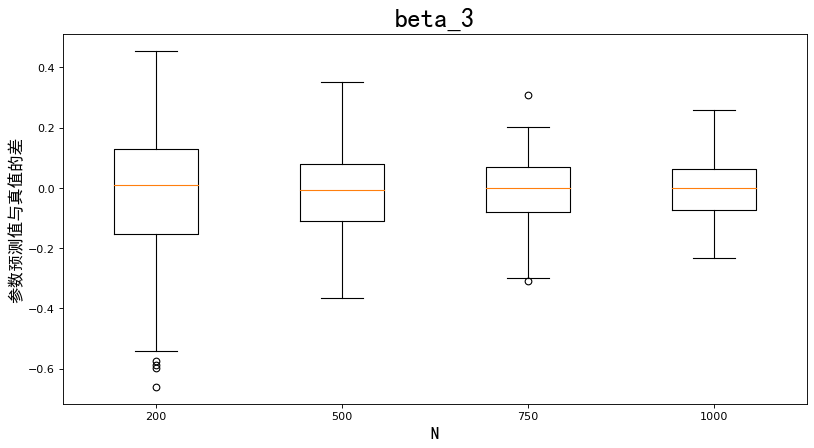

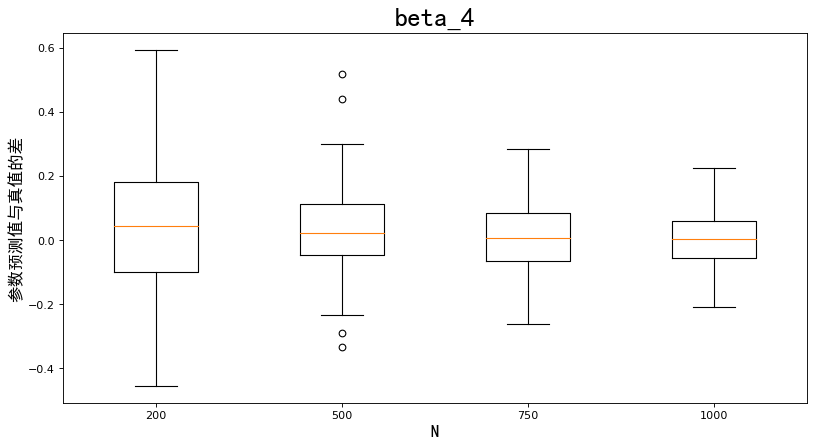

In [6]:
for j in range(4):
    data = np.zeros([R,1])
    labels = []
    for N in N_list:
        labels.append(N)
        data = np.append(data, results_dict[N][:,j].reshape(R,1), axis=1)
    data = data[:,1:]
    # 这里是对应每一个beta，画四个N的箱线图  
    plt.figure(figsize=(12,6),dpi=80)    
    plt.boxplot(data,labels=labels)
    plt.ylabel('参数预测值与真值的差', fontproperties=my_font,size = 15)
    plt.xlabel('N', fontproperties=my_font,size = 15)
    plt.title('beta_{}'.format(j+1),fontproperties=my_font)
    plt.show()

这是对每一个参数，绘制4个N值下的预测值与真值的差的箱线图。  
这几幅图也证明了我们算法的有效性，参数的预测值与真值的差都在0左右波动，最少的200数据量也已经取得了较好的结果。  
此外，这几幅图可以明显地看出，$\hat\beta_i-\beta_i$随着N的增大而趋于稳定，也即方差越来越小，拟合的效果越来越好。  

<h3 >Problem 2：征信系列-用户行为数据分析</h3>

1. 读入数据并了解各个自变量的含义；
2. 对变量交易笔数和所有用户行为均值分别绘制违约组和非违约组的对比箱线图，并分析是否违约与这些变量之间的关系，给出解读；
3. 用全部样本数据，以是否违约为因变量建立逻辑回归模型，利用 BIC 准则进行变量筛选，观察最终得到的回归系数并尝试解释对系数进行解释；
4. 使用任务 3 的模型，对全部样本进行预测，计算 AUC 值，并绘制 ROC 曲线，对模型的效果进行评估；
5. 任务 4 中对每个训练样本预测出了非违约的概率，按照非违约率从高到低排序，将全部样本分为 5 组人群：非违约率最高的 20%用户、…、非违约率最低的20%用户，计算五类人群的平均非违约概率，从高到低排序，绘制柱状图；对结果的商业应用进行解读。

<h4 >1. 读入数据并了解各个自变量的含义；</h4>

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import font_manager
my_font = font_manager.FontProperties(family='SimHei', size=24)

导入所用库和绘图等设置。

In [8]:
filename = 'simudata.csv'
data = pd.read_csv(filename)

读取数据。

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8032 entries, 0 to 8031
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   creded       8032 non-null   float64
 1   debitF       8032 non-null   int64  
 2   meanpay      8032 non-null   int64  
 3   billnum      8032 non-null   int64  
 4   debitM       8032 non-null   float64
 5   zhongxingM   8032 non-null   int64  
 6   sidaM        8032 non-null   int64  
 7   xindaiR      8032 non-null   float64
 8   cardnum      8032 non-null   int64  
 9   xindaiF      8032 non-null   int64  
 10  maxpay       8032 non-null   float64
 11  zhuanzhangF  8032 non-null   int64  
 12  gongjiaoF    8032 non-null   int64  
 13  zhuanzhangR  8032 non-null   float64
 14  age          8032 non-null   int64  
 15  gongjiaoR    8032 non-null   float64
 16  sidaF        8032 non-null   int64  
 17  sidaR        8032 non-null   float64
 18  zhongxingF   8032 non-null   int64  
 19  zhongx

初步查看数据，发现无空值。

In [10]:
data.describe()

,creded,debitF,meanpay,billnum,debitM,zhongxingM,sidaM,xindaiR,cardnum,xindaiF,...,sidaR,zhongxingF,zhongxingR,xiaofeiF,jinkaF,zhuanzhangM,gongjiaoM,youxiM,xindaiS,black
count,8032.000000,8032.000000,8.032000e+03,8032.000000,8.032000e+03,8.032000e+03,8.032000e+03,8032.000000,8032.000000,8032.000000,...,8032.000000,8032.000000,8032.000000,8032.000000,8032.000000,8.032000e+03,8032.000000,8032.000000,8032.000000,8032.000000
mean,0.144796,35.455802,2.717996e+05,74.471489,3.050731e+05,1.617706e+05,2.715348e+05,163.339720,6.394796,4.159985,...,148.532261,7.812251,237.543242,2.578312,6.101469,3.046979e+05,6079.254307,209.638073,106103.725818,0.333665
std,0.143946,35.141984,2.352257e+05,71.310466,2.597760e+05,1.714516e+05,2.460283e+05,104.671216,4.379306,3.633870,...,99.256973,8.336176,106.227388,3.035972,7.047664,2.963735e+05,7530.265840,260.277361,94056.103030,0.471551
min,0.000000,0.000000,0.000000e+00,0.000000,2.600000e+01,3.000000e+00,1.000000e+01,0.020000,0.000000,0.000000,...,0.160000,0.000000,0.170000,0.000000,0.000000,3.821000e+01,0.020000,0.000000,8.050000,0.000000
25%,0.020000,5.000000,5.047525e+04,11.000000,5.930946e+04,2.161650e+04,4.469200e+04,70.175000,3.000000,1.000000,...,57.222500,1.000000,157.150000,0.000000,1.000000,4.583786e+04,804.827500,28.047500,18240.015000,0.000000
50%,0.100000,25.000000,2.312770e+05,55.000000,2.648380e+05,9.791300e+04,2.197690e+05,155.520000,6.000000,4.000000,...,136.135000,5.000000,251.330000,1.000000,3.000000,2.145178e+05,2245.550000,75.050000,87971.440000,0.000000
75%,0.240000,57.000000,4.253420e+05,119.000000,4.796458e+05,2.610935e+05,4.338408e+05,241.020000,9.000000,7.000000,...,219.947500,13.000000,340.050000,4.000000,10.000000,4.963003e+05,9483.372500,329.990000,165942.247500,1.000000
max,0.820000,202.000000,1.346594e+06,427.000000,1.436086e+06,1.017770e+06,1.299826e+06,365.000000,26.000000,20.000000,...,365.000000,53.000000,365.000000,19.000000,44.000000,1.650050e+06,55745.070000,1939.000000,485178.350000,1.000000


展示数据统计信息。

In [11]:
data

,creded,debitF,meanpay,billnum,debitM,zhongxingM,sidaM,xindaiR,cardnum,xindaiF,...,sidaR,zhongxingF,zhongxingR,xiaofeiF,jinkaF,zhuanzhangM,gongjiaoM,youxiM,xindaiS,black
0,0.02,28,474795,4,784137.54,56826,307042,365.00,2,6,...,7.83,4,334.38,6,9,508646.02,297.83,66.02,5760.22,1
1,0.16,2,346573,32,1217.43,43644,15096,311.73,9,0,...,91.77,14,365.00,1,11,425876.24,3521.03,22.75,83872.62,1
2,0.32,56,168844,191,95001.76,279217,69815,42.32,8,0,...,36.05,10,27.08,1,2,492287.84,467.64,6.66,31110.55,1
3,0.01,28,69002,89,487782.48,273731,329437,81.60,15,1,...,10.08,8,191.04,1,8,240067.26,288.67,119.98,7876.13,1
4,0.19,6,408647,104,22039.56,13529,24725,254.60,17,9,...,324.21,23,248.39,7,0,455464.47,11834.25,28.97,13765.38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8027,0.31,7,134240,103,45087.85,136167,350033,127.70,1,4,...,215.10,34,82.39,6,1,812731.90,1058.44,647.91,123803.67,1
8028,0.17,0,322906,81,307575.51,390132,494558,64.52,3,1,...,276.75,10,23.82,1,0,93830.00,1299.33,41.21,7532.98,0
8029,0.18,61,72099,57,492093.45,80562,705958,341.86,2,6,...,32.11,1,365.00,0,6,83075.89,28291.09,3.94,63898.09,0
8030,0.07,13,152864,134,506255.19,85309,31359,158.15,10,10,...,45.73,16,277.75,5,1,409679.28,1994.96,38.80,2994.33,0


查看部分数据。

In [12]:
print('数据集大小:',data.shape[0])
print('数据集特征数:',data.shape[1])
print('数据集特征列表:',list(data.columns))

数据集大小: 8032
数据集特征数: 27
数据集特征列表: ['creded', 'debitF', 'meanpay', 'billnum', 'debitM', 'zhongxingM', 'sidaM', 'xindaiR', 'cardnum', 'xindaiF', 'maxpay', 'zhuanzhangF', 'gongjiaoF', 'zhuanzhangR', 'age', 'gongjiaoR', 'sidaF', 'sidaR', 'zhongxingF', 'zhongxingR', 'xiaofeiF', 'jinkaF', 'zhuanzhangM', 'gongjiaoM', 'youxiM', 'xindaiS', 'black']


<h4 >2. 对变量交易笔数和所有用户行为均值分别绘制违约组和非违约组的对比箱线图，并分析是否违约与这些变量之间的关系，给出解读；</h4>

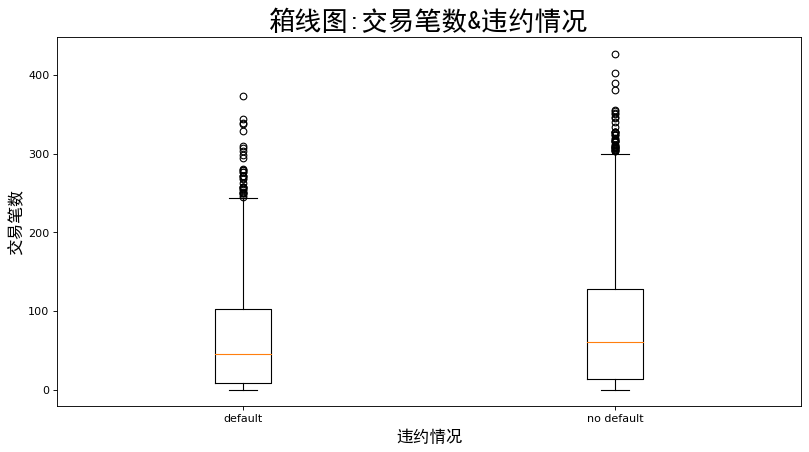

In [13]:
# 取出数据
billnum_def = data[data['black']==1]['billnum']
billnum_ndf = data[data['black']==0]['billnum']

# 绘图
labels = ['default','no default']
plt.figure(figsize=(12,6),dpi=80)    
plt.boxplot([billnum_def,billnum_ndf],labels=labels)
plt.ylabel('交易笔数', fontproperties=my_font,size = 15)
plt.xlabel('违约情况', fontproperties=my_font,size = 15)
plt.title('箱线图:交易笔数&违约情况',fontproperties=my_font)
plt.show()

从交易笔数和违约情况箱线图来看，未违约者的平均交易笔数会相对更多。从某种意义上来说，也可以理解为交易笔数越多违约的概率越小。

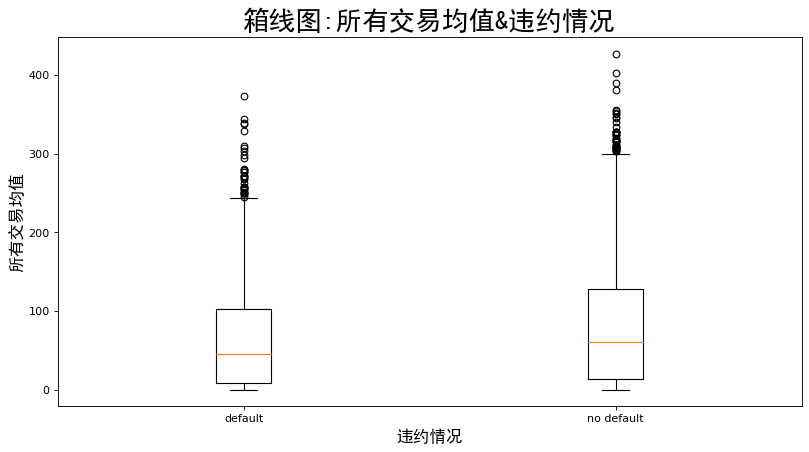

In [14]:
# 取出数据
meanpay_def = data[data['black']==1]['meanpay']
meanpay_ndf = data[data['black']==0]['meanpay']

# 绘图
labels = ['default','no default']
plt.figure(figsize=(12,6),dpi=80)    
plt.boxplot([billnum_def,billnum_ndf],labels=labels)
plt.ylabel('所有交易均值', fontproperties=my_font,size = 15)
plt.xlabel('违约情况', fontproperties=my_font,size = 15)
plt.title('箱线图:所有交易均值&违约情况',fontproperties=my_font)
plt.show()

从所有交易均值和违约情况箱线图来看，未违约者的所有交易均值的中位数会相当更大。也即未违约者相对于违约者会有更大的交易均值。

<h4 >3. 用全部样本数据，以是否违约为因变量建立逻辑回归模型，利用 BIC 准则进行变量筛选，观察最终得到的回归系数并尝试解释对系数进行解释；</h4>

In [15]:
import statsmodels.api as sm

X = data.drop('black',axis=1)
X['const'] = 1
# 得到自变量，并添加全一列拟合常数
y = data['black']
model_0 = sm.Logit(y, X) 
results_0 = model_0.fit(disp=0)  # 不打印收敛信息
yFit_0 = results_0.fittedvalues
print(results_0.summary()) 
print('bic:',results_0.bic)

                           Logit Regression Results                           
Dep. Variable:                  black   No. Observations:                 8032
Model:                          Logit   Df Residuals:                     8005
Method:                           MLE   Df Model:                           26
Date:                Mon, 03 Apr 2023   Pseudo R-squ.:                  0.2595
Time:                        09:51:42   Log-Likelihood:                -3787.1
converged:                       True   LL-Null:                       -5114.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
creded         -4.0495      0.223    -18.156      0.000      -4.487      -3.612
debitF         -0.0117      0.001    -13.380      0.000      -0.013      -0.010
meanpay     -2.322e-06   1.36e-07    -17.107    

我们使用statsmodels中的Logit函数进行逻辑回归，这里给出所有数据所有属性的模型回归结果。
  
由于这不是我们最终的模型，这里不加分析。

In [16]:
def stepwise(X,y,included, verbose = True):
    '''X为所有可能的自变量构成的DataFrame,
      y为响应变量，
      included包含当前被包含在模型内的属性名
      verbose为true时会打印详细的选取信息
      '''
    included = list(included)
    while True:
        changed=False
        excluded=list(set(X.columns)-set(included))
        if included:
            model=sm.Logit(y,X[included]).fit(disp=0)
            now_BIC = model.bic
        else:
            now_BIC = float('inf')
        
        # forward step
        ex_BIC_val=pd.Series(index=excluded,dtype='float64')
        for new_column in excluded: 
            # 逐一考虑是否要将某属性加入模型
            model=sm.Logit(y,X[included+[new_column]]).fit(disp=0)
            ex_BIC_val[new_column] = model.bic
            if  verbose :
                print('       ','add',new_column,model.bic)
        min_BIC=ex_BIC_val.min()
        if min_BIC < now_BIC:
            changed=True
            add_feature=ex_BIC_val.idxmin()
            included.append(add_feature)
            print("Add {:20} with BIC_value   {:.6}".format(add_feature,min_BIC))
            
        model=sm.Logit(y,X[included]).fit(disp=0)
        now_BIC = model.bic   
        # backward step
        if len(included) > 1:
            in_BIC_val=pd.Series(index=included,dtype='float64')
            for drop_column in included: 
                # 逐一考虑是否要将某属性从模型中剔除
                model=sm.Logit(y,X[list(set(included)-set([drop_column]))]).fit(disp=0)
                in_BIC_val[drop_column] = model.bic
                if  verbose :
                    print('      ','drop',drop_column,model.bic)
            min_BIC=in_BIC_val.min()
            if min_BIC < now_BIC:
                changed=True
                drop_feature=in_BIC_val.idxmin()
                included.remove(drop_feature)
                print("Drop {:20} with BIC_value   {:.6}".format(drop_feature,min_BIC))
            
        if not changed: # 如果某一轮循环未改变模型，则终止迭代
            break
    return included # 输出最终模型包含的属性名list

这里的逐步回归函数和上一份作业大体相同。

In [17]:
best = stepwise(X,y,included=X.columns, verbose = False)

Drop sidaR                with BIC_value   7813.91
Drop xindaiS              with BIC_value   7812.33
Drop youxiM               with BIC_value   7810.5
Drop zhongxingM           with BIC_value   7809.29
Drop zhuanzhangM          with BIC_value   7809.03


上面从包含全部属性开始的逐步回归，下面从不包含属性开始的逐步回归，将剔除/加入属性的过程和对应的BIC值进行了输出。 
  
在这里指出，这两种方向最终的结果集合相同，这不是一件很常见的事情。

In [18]:
best1 = stepwise(X,y,included=[], verbose = False)

Add meanpay              with BIC_value   9966.81
Add creded               with BIC_value   9671.92
Add xindaiR              with BIC_value   9387.32
Add debitF               with BIC_value   9169.34
Add cardnum              with BIC_value   9019.14
Add sidaM                with BIC_value   8860.17
Add xindaiF              with BIC_value   8739.19
Add billnum              with BIC_value   8593.74
Add zhuanzhangF          with BIC_value   8483.15
Add const                with BIC_value   8366.05
Add maxpay               with BIC_value   8173.51
Add age                  with BIC_value   8073.5
Add gongjiaoF            with BIC_value   7976.91
Add zhuanzhangR          with BIC_value   7876.72
Add debitM               with BIC_value   7861.24
Add gongjiaoR            with BIC_value   7846.33
Add xiaofeiF             with BIC_value   7836.14
Add sidaF                with BIC_value   7827.08
Add gongjiaoM            with BIC_value   7819.14
Add zhongxingF           with BIC_value   7814.78
A

In [19]:
for item in best:
    print(item,end='  ')

creded  debitF  meanpay  billnum  debitM  sidaM  xindaiR  cardnum  xindaiF  maxpay  zhuanzhangF  gongjiaoF  zhuanzhangR  age  gongjiaoR  sidaF  zhongxingF  zhongxingR  xiaofeiF  jinkaF  gongjiaoM  const  

展示最终模型考虑的全部属性。

In [20]:
model_1 = sm.Logit(y, X[best]) 
results_1 = model_1.fit(disp=0) 
print(results_1.summary())
print('bic:',results_1.bic)

                           Logit Regression Results                           
Dep. Variable:                  black   No. Observations:                 8032
Model:                          Logit   Df Residuals:                     8010
Method:                           MLE   Df Model:                           21
Date:                Mon, 03 Apr 2023   Pseudo R-squ.:                  0.2559
Time:                        09:52:02   Log-Likelihood:                -3805.6
converged:                       True   LL-Null:                       -5114.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
creded         -4.0148      0.222    -18.090      0.000      -4.450      -3.580
debitF         -0.0117      0.001    -13.415      0.000      -0.013      -0.010
meanpay     -2.322e-06   1.35e-07    -17.150    

In [21]:
results_1.params.sort_values()

const         -7.100892e+00
creded        -4.014808e+00
debitF        -1.169632e-02
billnum       -4.131022e-03
meanpay       -2.322303e-06
sidaM         -1.075749e-06
debitM        -5.523676e-07
maxpay         3.461309e-07
gongjiaoM      1.527860e-05
zhongxingR     9.010120e-04
zhuanzhangR    2.398801e-03
sidaF          4.818615e-03
xindaiR        5.427944e-03
gongjiaoR      5.822781e-03
zhongxingF     1.249489e-02
jinkaF         1.410877e-02
zhuanzhangF    1.713925e-02
xiaofeiF       4.046551e-02
age            6.783358e-02
cardnum        1.146052e-01
xindaiF        1.187577e-01
gongjiaoF      2.331233e-01
dtype: float64

这里即为我们模型的最终结果，逐步回归得到的最优bic值为7809.

- 最终模型共有22个参数，除去一个常数项，共选取了21项特征，在开始的26项特征中筛去了五项，这五项分别是四大R、信贷S、游戏M 、中型M 、转账M，可能这五种属性对预测违约的价值不大或者是被其余数据包含了其信息。  
- 其中有6个特征的参数为负数，即"借贷比率、借记类F、交易笔数、所有行为均值、四大M、借记类M"，参数为负数意味着这些特征越大、预测结果越接近0类别（即未违约），也即这些数值大的用户会更倾向于守约。
- 剩余15个特征的参数均为正数，意味着这些特征越大，预测结果越接近1累呗（即违约）。
- 这里参数$ \beta $ 的意义是，在其他属性保证不变的情况下，相应的属性增加一个单位会导致违约这件事的胜率(胜率的定义为$\frac{p}{1-p}$,其中p为违约概率)变为原本的$e^\beta$倍。
- 这里我没有对数值展开一些对比分析，也不能展开对比分析，这是因为我们前文没有对数据进行归一化，各个参数间的数值大小关系没有意义，如果想要对比各数据对违约情况的影响大小的话下次应当先进行归一化，或者用大致的量纲乘以参数再进行比较。



<h4 >4. 使用任务 3 的模型，对全部样本进行预测，计算 AUC 值，并绘制 ROC 曲线，对模型的效果进行评估；</h4>

In [22]:
yFit_1 = results_1.fittedvalues 
# sigmoid(yFit_1) == yFit_2
yFit_2=results_1.predict(X[best])

这里给出了两个 fit 结果，区别在于yFit_2相较于yFit_1多了一个sigmoid过程，也即 sigmoid(yFit_1)与 yFit_2相等 。  
yFit_1 可以视为对是否会违约的风险的某种评价，yFit_2 则可以视为我们对其违约概率的预测。

In [23]:
from sklearn.metrics import roc_auc_score,roc_curve
auc_score = roc_auc_score(y,yFit_1)

fpr,tpr,threshold = roc_curve(y,yFit_1)

auc_score1 = roc_auc_score(y,yFit_2)
print(auc_score,'  ',auc_score1)

0.8254643263503112    0.8254643263503112


我们借用sklearn.metrics库来完成AUC的计算和ROC曲线的绘制，这里用了yFit_1和yFit_2两者来计算AUC，其实结果是相同的。

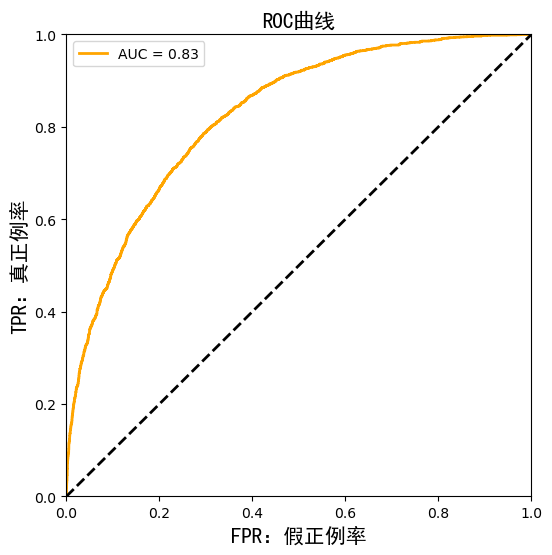

In [24]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='orange',
         lw=2, label='AUC = %0.2f' % auc_score)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR：假正例率',fontproperties=my_font,size = 15)
plt.ylabel('TPR：真正例率',fontproperties=my_font,size = 15)
plt.title('ROC曲线',fontproperties=my_font,size = 15)
plt.legend(loc="best")
plt.show()

从ROC曲线中可以看出本模型的预测效果较好，AUC面积占到了0.83，ROC曲线上凸。

<h4 >5. 任务 4 中对每个训练样本预测出了非违约的概率，按照非违约率从高到低排序，将全部样本分为 5 组人群：非违约率最高的 20%用户、…、非违约率最低的20%用户，计算五类人群的平均非违约概率，从高到低排序，绘制柱状图；对结果的商业应用进行解读。</h4>

In [25]:
sorted_y = yFit_2.sort_values()
cut_y = pd.qcut(sorted_y,5,labels=False)

将yFit_2根据值进行排序，并借助 pd.qcut根据数量五等分，并且将其取值改为0-4.

In [26]:
cut_y.value_counts()

0    1607
4    1607
1    1606
2    1606
3    1606
dtype: int64

上面展示分组后的结果。

In [27]:
prob_result = []
for i in range(5):
    p = 1 - np.sum(y[cut_y == i])/len(y[cut_y == i])
    prob_result.append(p)

根据分组逐组统计实际的未违约概率。

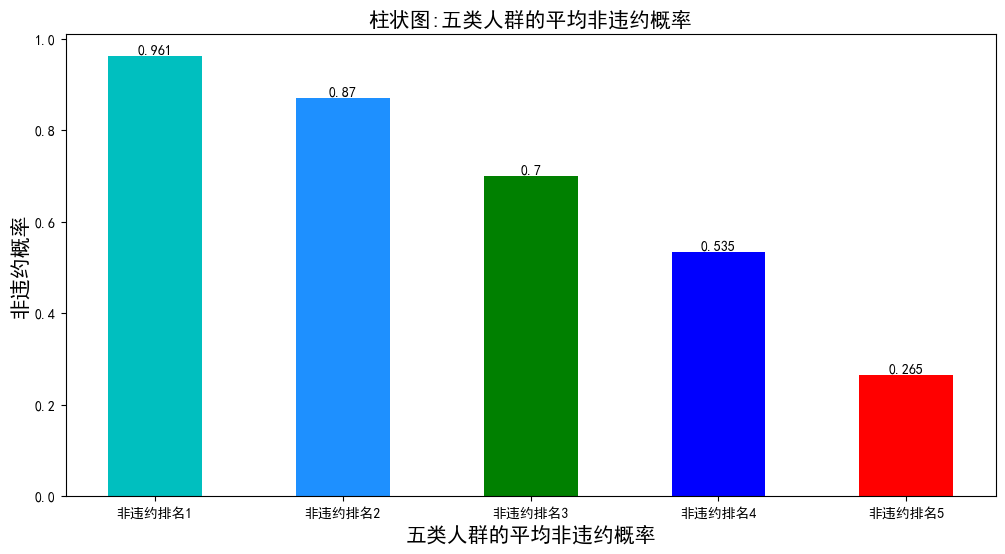

In [28]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.figure(figsize=(12, 6))

x = ['非违约排名1','非违约排名2','非违约排名3','非违约排名4','非违约排名5']
rects = plt.bar(x,prob_result,width=0.5, color=['c','dodgerblue','g','b','r'])
for rect in rects:  #rects 是三根柱子的集合
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height, round(height,3), size=10, ha='center', va='bottom')
    # 添加对应的数字

plt.title("柱状图:五类人群的平均非违约概率",fontproperties=my_font,size = 15)
plt.xlabel('五类人群的平均非违约概率',fontproperties=my_font,size = 15)
plt.ylabel('非违约概率',fontproperties=my_font,size = 15)
plt.show()


上图为描述五类人群的平均非违约概率的柱状图，非违约排名1即为我们预测不违约概率最高的20%的人，非违约排名5即为我们模型预测最可能违约的20%的人，其余三组以此类推，y轴即描述了他们实际上的非违约人数占比。  
可以看到，我们根据特征预测违约概率高的人，实际上违约概率确实较高；我们预测概率较低的人，实际上违约概率确实相对较低。不过我们模型的训练过程中用到了真实结果，而且没有划分训练集、验证集和测试集，因此这种良好表现是应该的。  

这启示公司在实际经营活动中可以考虑从特征出发建模分析用户的违约可能。  


In [29]:
who

IRLS	 N	 N_list	 R	 X	 Y	 auc_score	 auc_score1	 best	 
best1	 billnum_def	 billnum_ndf	 cut_y	 data	 diff	 filename	 font_manager	 fpr	 
height	 i	 item	 j	 labels	 meanpay_def	 meanpay_ndf	 model_0	 model_1	 
my_font	 np	 p	 pd	 plt	 predict_beta	 prob_result	 rect	 rects	 
results_0	 results_1	 results_dict	 roc_auc_score	 roc_curve	 sigmoid	 sm	 sorted_y	 stepwise	 
threshold	 tpr	 true_beta	 x	 y	 yFit_0	 yFit_1	 yFit_2	 


In [30]:
whos

Variable        Type                    Data/Info
-------------------------------------------------
IRLS            function                <function IRLS at 0x000001A94CE08DC0>
N               int                     1000
N_list          list                    n=4
R               int                     200
X               DataFrame                     creded  debitF  mea<...>n[8032 rows x 27 columns]
Y               ndarray                 1000x1: 1000 elems, type `int32`, 4000 bytes
auc_score       float64                 0.8254643263503112
auc_score1      float64                 0.8254643263503112
best            list                    n=22
best1           list                    n=22
billnum_def     Series                  0         4\n1        32\<...>ength: 2680, dtype: int64
billnum_ndf     Series                  4       104\n5         3\<...>ength: 5352, dtype: int64
cut_y           Series                  1814    0\n3877    0\n601<...>ength: 8032, dtype: int64
data        